In [2]:
import numpy as np
import pandas as pd

## Prerequisites

In [3]:
# 파이썬을 아나콘다로 설치한 경우, 아래 명령어 대신 아나콘다 네비게이터(Anaconda Navigator)를 실행한 뒤
# 좌측의 환경(Environment) 탭에서 설치할 수 있습니다.
!pip install tensorflow

In [4]:
# 파이썬을 아나콘다로 설치한 경우, 아래 명령어 대신 아나콘다 네비게이터(Anaconda Navigator)를 실행한 뒤
# 좌측의 환경(Environment) 탭에서 설치할 수 있습니다.
!pip install keras

## MNIST Dataset

이번 과제는 [MNIST 필기체 데이터셋](http://yann.lecun.com/exdb/mnist/)을 활용하여 필기체 이미지를 인식하는 이미지 인식 알고리즘을 Single-layer Neural Network로 작성합니다.

가로 28px, 세로 28px의 필기체 이미지가 주어지며, 필기체는 숫자 0부터 9까지 총 10개의 Label로 구성되어 있습니다. 이미지는 컬러가 없는 흑백 데이터이며, 한 픽셀의 값은 0 ~ 255 입니다. (0일수록 어둡고, 255일수록 밝습니다)

데이터는 60,000개의 Train 데이터와 10,000개의 Test 데이터가 주어지는데, Train 데이터로 Single-layer Neural Network를 학습한 뒤 Test 데이터로 정확도(accuracy)를 측정합니다. 각 변수의 세부 정보는 다음과 같습니다.

  * **X_train**: **Train 데이터의 Feature** 입니다. 가로 28px, 세로 28px, 총 60,000개의 데이터로 구성되어 있습니다. 픽셀 하나의 값은 0 ~ 255 입니다. (0일수록 어둡고, 255일수록 밝습니다)
  * **y_train**: **Train 데이터의 Label** 입니다. 총 60,000 개이며, 이미지가 어떤 숫자를 나타내는지가 적혀 있습니다. 값은 0부터 9까지 입니다.
  * **X_test**: **Test 데이터의 Feature** 입니다. 가로 28px, 세로 28px, 총 10,000개의 데이터로 구성되어 있습니다. 픽셀 하나의 값은 0 ~ 255 입니다. (0일수록 어둡고, 255일수록 밝습니다)
  * **y_test**: **Test 데이터의 Label** 입니다. 총 10,000 개이며, 이미지가 어떤 숫자를 나타내는지가 적혀 있습니다. 값은 0부터 9까지 입니다.
  
** 주의 사항 **
  * 이전에 Iris Dataset 문제를 풀었던 코드를 조금만 응용하면 매우 쉽게 MNIST 데이터셋 문제를 풀 수 있습니다.
  * accuracy가 잘 올라가지 않고 그 이유를 잘 모르겠다면, Loss Function(=Cross Entropy)를 병행해서 사용해보세요. 앞서 언급드린대로 Loss Function은 "학습이 잘 될수록 0에 수렵하고, 학습이 잘 되지 않을수록 무한대로 발산합니다." 즉, Loss Function을 사용할 결과가 무한대로 발산하고 있다면 무언가 제대로 풀리지 않고 있다는 것입니다.

In [5]:
from keras.datasets import mnist

((X_train, y_train), (X_test, y_test)) = mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


[5 0 4 1 9 2 1 3 1 4]


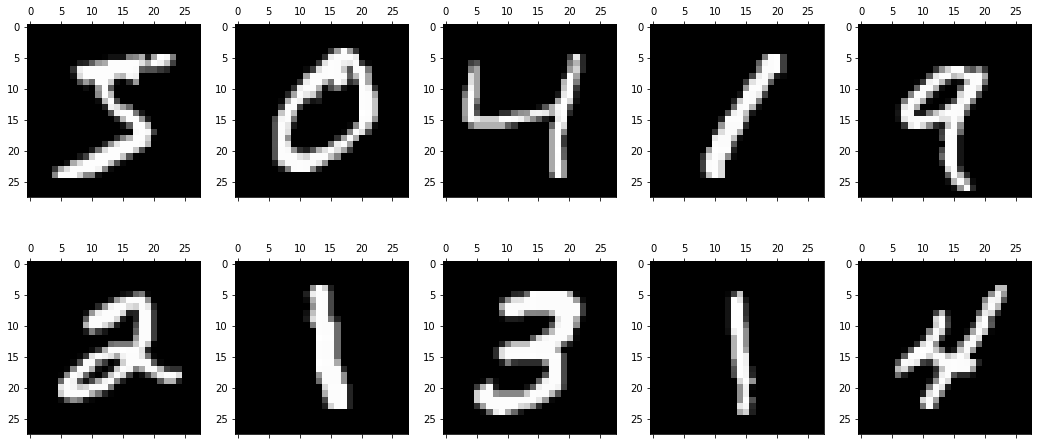

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()

print(y_train[0:10])

figures, axes = plt.subplots(nrows=2, ncols=5)
figures.set_size_inches(18, 8)

axes[0][0].matshow(X_train[0])
axes[0][1].matshow(X_train[1])
axes[0][2].matshow(X_train[2])
axes[0][3].matshow(X_train[3])
axes[0][4].matshow(X_train[4])
axes[1][0].matshow(X_train[5])
axes[1][1].matshow(X_train[6])
axes[1][2].matshow(X_train[7])
axes[1][3].matshow(X_train[8])
axes[1][4].matshow(X_train[9])

## Preprocessing

In [7]:
X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


In [8]:
from keras.utils import to_categorical

# One hot encoding을 합니다.
# np.eye(10)[y_train]과 동일합니다.
y_train_hot = to_categorical(y_train)

# np.eye(10)[y_test]와 동일합니다.
y_test_hot = to_categorical(y_test)

print(y_train_hot.shape)
print(y_test_hot.shape)

(60000, 10)
(10000, 10)


### Define Sigmoid

In [9]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))

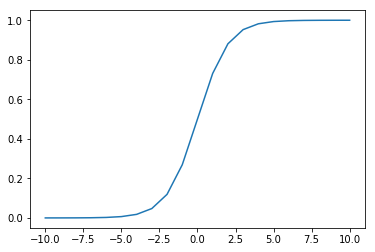

In [10]:
xx = np.linspace(-10, 10, num=21)
yy = sigmoid(xx)

plt.plot(xx, yy)

### Define Cross-Entropy

In [11]:
def cross_entropy(actual, predict, eps=1e-15):
    actual = np.array(actual)
    predict = np.array(predict)

    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)

    loss = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    
    return -1.0 * loss.mean()

### Gradient Descent

In [13]:
num_epoch = 100
learning_rate = 0.1

w = np.random.uniform(low=-1.0, high=1.0, size=(784, 10))
b = np.random.uniform(low=-1.0, high=1.0, size=10)

for epoch in range(num_epoch):
    y_predict_hot = X_train.dot(w) + b
    y_predict_hot = sigmoid(y_predict_hot)
    
    y_predict = np.argmax(y_predict_hot, axis=1)

    accuracy = (y_predict == y_train).mean()
    if accuracy > 0.80:
        break
        
    loss = cross_entropy(y_train_hot, y_predict_hot)

    if epoch % 10 == 0:
        print("{0:2} loss = {1:.5f}, accuracy = {2:.5f}".format(epoch, loss, accuracy))

    w = w - learning_rate * X_train.T.dot(y_predict_hot - y_train_hot)
    b = b - learning_rate * (y_predict_hot - y_train_hot).mean(axis=0)

print("----" * 10)
print("{0:2} loss = {1:.5f}, accuracy = {2:.5f}".format(epoch, loss, accuracy))

/Users/hellothere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


 0 loss = 17.66080, accuracy = 0.04057
10 loss = 1.81394, accuracy = 0.70797
20 loss = 1.88872, accuracy = 0.70040
----------------------------------------
26 loss = 1.65263, accuracy = 0.80475


## Evaluate

### Train

In [14]:
y_predict_hot = X_train.dot(w) + b
y_predict_hot = sigmoid(y_predict_hot)
y_predict = np.argmax(y_predict_hot, axis=1)

train_result = pd.DataFrame({'actual': y_train, 'predict': y_predict})

train_accuracy = (train_result["actual"] == train_result["predict"]).mean()

print("Accuracy(train) = {0:.5f}".format(train_accuracy))

print(train_result.shape)
train_result.head(10)

Accuracy(train) = 0.80475
(60000, 2)


/Users/hellothere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


actual  predict
0       5        3
1       0        0
2       4        4
3       1        1
4       9        4
5       2        2
6       1        1
7       3        3
8       1        1
9       4        4

### Test

In [16]:
y_predict_hot = X_test.dot(w) + b
y_predict_hot = sigmoid(y_predict_hot)
y_predict = np.argmax(y_predict_hot, axis=1)

test_result = pd.DataFrame({'actual': y_test, 'predict': y_predict})

test_accuracy = (test_result["actual"] == test_result["predict"]).mean()

print("Accuracy(test) = {0:.5f}".format(test_accuracy))

print(test_result.shape)
test_result.head(10)

Accuracy(test) = 0.81530
(10000, 2)


/Users/hellothere/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


actual  predict
0       7        7
1       2        2
2       1        1
3       0        0
4       4        4
5       1        1
6       4        4
7       9        9
8       5        0
9       9        9